In [212]:
import os
import shutil 
import math
import sklearn
from sklearn.metrics import confusion_matrix
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn

# torch package
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.utils.data as data
import torch.optim as optim
import torch.nn.functional as F
from torch import argmax
from torch.nn.functional import relu
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, datasets

### GENERAL CONFIGURATIONS

In [213]:
# Set seed value for reproducibility purpose
torch.manual_seed(24)
np.random.seed(24)

In [214]:
# use GPU if it is give otherwise use CPU
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu"); device

device(type='cpu')

### DATA PREPARATION AND PREPROCESSING

In [215]:
"""
Since we cannot apply transform directly to the subset object, we create this class to do it
"""
class ApplyTransformDataset(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
            return x, y

    def __len__(self):
        return len(self.subset)

In [216]:
# create transformation for train set. We use random crop, random horizonal flip and normalize for the train set
transform_train = transforms.Compose([
        transforms.RandomCrop(28, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
])

# create transformation for test set. We use only normalize for the test set and validation set
transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
])

In [217]:
# load train set
trainset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=None)
# load test set and apply the transformation to it
testset = datasets.FashionMNIST(root='./data', train=False, download=False, transform=transform_test)

In [218]:
# split train set to 2 subset: train set and validation set
length = [int(len(trainset)*0.8), int(len(trainset)*0.2)]
trainset, validset = torch.utils.data.random_split(trainset, length)

# apply transform to train set and validation set
trainset = ApplyTransformDataset(trainset, transform_train)
validset = ApplyTransformDataset(validset, transform_test)

# create data loader for train set, valid set and test set
trainloader = data.DataLoader(trainset, batch_size=128, shuffle=True)
validloader = data.DataLoader(validset, batch_size=100, shuffle=False)
testloader = data.DataLoader(testset, batch_size=100, shuffle=False)

### DATA EXPLORATION

In [219]:
# list the class names corresponsing to values ranging from 0 to 9
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", 
               "Sandal", "Shirt", "Sneaker", "Bag",  "Ankle boot"]

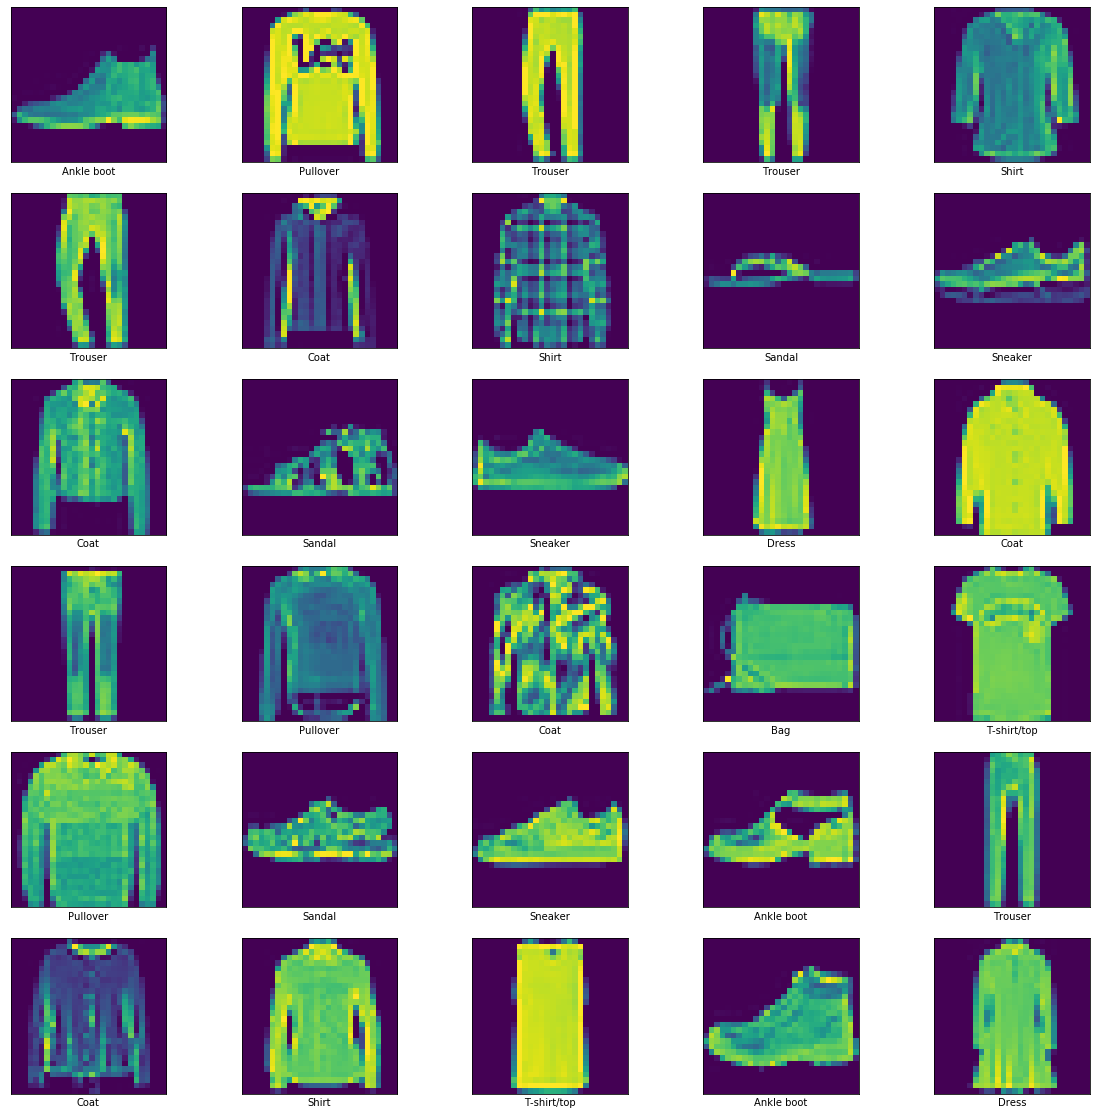

In [220]:
# plot the first 30 images from the train set

# set figure size
plt.figure(figsize=(20,20))
for i in range(30):
    # add a subplot to the current figure
    plt.subplot(6,5,i+1)
    # remove x ticks and y ticks around the images
    plt.xticks([])
    plt.yticks([])
    # display the image
    plt.imshow(testset[i][0].reshape(28,28))
    # displaye the corresponding labels
    plt.xlabel(class_names[testset.targets[i]])
plt.show()

### MODEL ARCHITECTURES

Model 1: The three-layer neural network

In [221]:
class NeuralNet(nn.Module):
    """
    The class implements the three hidden layer neural network object
    
    The network architecture consists of 5 layers: input layer --> hidden1 --> hidden2 --> hidden3 --> output layer
    """
    def __init__(self, input_size=(28,28), output_size=10, n_neuron=300):
        super().__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.n_neuron = n_neuron
        
        # calcualte the new size of input after flattening
        flattened_size = input_size[0]*input_size[1] 
        
        # create hidden layers
        self.hidden1 = nn.Linear(flattened_size, n_neuron, bias=True)
        self.hidden2 = nn.Linear(n_neuron, n_neuron, bias=True)
        self.hidden3 = nn.Linear(n_neuron, n_neuron, bias=True )
        
        # create output layer
        self.output_layer = nn.Linear(n_neuron, output_size, bias=True)
        
        
    def forward(self, x):
        # Flatten the input to the shape (N, H) with N is the batch size, H is the input length
        out = x.view(x.size(0), -1)
        out = relu(self.hidden1(out))
        out = relu(self.hidden2(out))
        out = relu(self.hidden3(out))
        out = self.output_layer(out)
        return out
    
    
    
def nn3():
    """
    Call the function to create a three-hidden-layer neural network
    """
    model = NeuralNet()
    return model

Model 2: The normal convolutional neural network

In [222]:
class ConvolutionalNeuralNet(nn.Module):
    """
    The class implements a normal convolutional neural network object
    
    The netowrk architecture consists of 4 groups:
    - group1-3: CONV -> BN -> RELU -> CONV -> BN -> RELU -> POOLING -> DROPOUT
    - group4: a fully connected network including 3 layers. The first layer has 1024 neurons, 
    the second one has 512 neurons and the last on has 10 neurons.
    """
    
    def __init__(self, input_size=(28,28), output_size=10):
        super().__init__()
    
        # group 1
        self.conv1_1  = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=(3,3), padding=1)
        self.bn1_1    = nn.BatchNorm2d(num_features=64)
        self.conv1_2  = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3,3))
        self.bn1_2    = nn.BatchNorm2d(num_features=64)
        self.pool1    = nn.MaxPool2d(kernel_size=2)
        self.dropout1 = nn.Dropout(p=0.2)
        
        # group 2
        self.conv2_1  = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3,3), padding=1)
        self.bn2_1    = nn.BatchNorm2d(num_features=128)
        self.conv2_2  = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3,3))
        self.bn2_2    = nn.BatchNorm2d(num_features=128)
        self.pool2    = nn.MaxPool2d(kernel_size=2)
        self.dropout2 = nn.Dropout(p=0.3)
        
        # group 3
        self.conv3_1  = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3,3), padding=1)
        self.bn3_1    = nn.BatchNorm2d(num_features=256)
        self.conv3_2  = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3,3))
        self.bn3_2    = nn.BatchNorm2d(num_features=256)
        self.pool3    = nn.MaxPool2d(kernel_size=2)
        self.dropout3 = nn.Dropout(p=0.4)
               
        # group 4
        self.linear1 = nn.Linear(256, 1024)
        self.linear2 = nn.Linear(1024, 512)
        self.linear3 = nn.Linear(512, 10)
        
        for m in self.modules():
            # normalize the intial value for weights for kernels in the convolutional layer
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            # set initial value for weights and biases in batch normalization layer
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            # set initial value for biases in batch normalization layer
            elif isinstance(m, nn.Linear):
                m.bias.data.zero_()
        
        
    def forward(self, x):
        out = x
        # input -> group 1
        out = self.bn1_1(relu(self.conv1_1(out)))
        out = self.bn1_2(relu(self.conv1_2(out)))
        out = self.pool1(out)
        out = self.dropout1(out)
        
        # group 1 -> group 2
        out = self.bn2_1(relu(self.conv2_1(out)))
        out = self.bn2_2(relu(self.conv2_2(out)))
        out = self.pool2(out)
        out = self.dropout2(out)
        
        # group 2 -> group 3
        out = self.bn3_1(relu(self.conv3_1(out)))
        out = self.bn3_2(relu(self.conv3_2(out)))
        out = self.pool3(out)
        out = self.dropout3(out)
        
        # group 3 -> group 4
        # flatten the input
        out = out.view(out.size(0), -1)
        out = relu(self.linear1(out))
        out = self.dropout2(out)
        out = relu(self.linear2(out))
        out = self.dropout1(out)
        out = self.linear3(out)
        return out
    
    
    
def cnn():
    """
    Call the function to create a normal convolutional neural network
    """
    model = ConvolutionalNeuralNet()
    return model      

Model 3: The wide residual network

In [223]:
"""
- in residual network there are two types of block: basic and bottleneck. 
(Kaiming He, Xiangyu Zhang, Shaoqing Ren, and Jian Sun. Deep residual learning for
image recognition. CoRR, abs/1512.03385, 2015.)

- since the bottleneck is used to make the network thinner, we do not use it in the wide resnet implementation.

- for the basic block, the author has proved the superior of the pre-activation architect over the original one, 
so we will use the pre-activation residual block as our basic block. 
( Kaiming He, Xiangyu Zhang, Shaoqing Ren, and Jian Sun. Identity mappings in deep
residual networks. CoRR, abs/1603.05027, 2016.
"""

# Code modified from https://github.com/zhunzhong07/Random-Erasing/blob/master/models/fashion/wideresnet.py~

class BasicBlock(nn.Module):
    """
    This class implement the pre-activation residual block
    In the basic block: we separate three type of inputs: input of the block, input of the residual path,
    and input of the shortcut (identity path)
    
    - input of the block is the pure input (do not have any function applied)
    - input of the residual path is the input that goes to the residual path
    - input of the shortcut (identity path) is the input that goes to the shortcut (identity path)
    The outputs are also defined in the same manner as the inputs
    """
    
    def __init__(self, in_planes, out_planes, stride, dropRate=0.0):
        super().__init__()
        # order: BN -> RELU -> CONV
        self.bn1   = nn.BatchNorm2d(in_planes)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        
        # order: BN -> RELU -> CONV
        self.bn2   = nn.BatchNorm2d(out_planes)
        self.relu2 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_planes, out_planes, kernel_size=3, stride=1, padding=1, bias=False)
        
        self.droprate = dropRate
        
        # Check whether the block input channels (the input depth) is the same as the block output channels (the output depth)
        self.equalInOut = (in_planes == out_planes)
        
        # If the block input and block output channels are different, 
        # we add one conv layer with kernel size = (1,1) in the shortcut path to make its output has the same channels as the output of the block
        # Depending on the specific situation, the [1x1] conv layer also has the effect of reducing the (width and heigh of the block input) by increasing stride value
        self.convShortcut = (not self.equalInOut) and nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, padding=0, bias=False) or None
        
        
    def forward(self, x):
        # If the block input channels is different from the block output channels, 
        # we apply batch normalization and activation function to the input of both residual path and identity path
        if not self.equalInOut:
            x = self.relu1(self.bn1(x))
        # Otherwise keep the input of identity path unchanged and apply batch normalization and activation function to the input of the residual path
        else:
            out = self.relu1(self.bn1(x))
        # apply the first convolutional layer in the residual path
        out = self.conv1(out if self.equalInOut else x)
        
        out = self.relu2(self.bn2(out))
        
        # apply the dropout if it is given
        if self.droprate > 0:
            out = F.dropout(out, p=self.droprate, training=self.training)
        
        # apply the second convolutional layer in the residual path
        out = self.conv2(out)
        
        # return the sum of two outputs from two paths
        return torch.add(x if self.equalInOut else self.convShortcut(x), out)
    
    
    
class NetworkBlock(nn.Module):
    """
    The object of this class represents for a single group in the wide residual network
    """
    def __init__(self, n_blocks, in_planes, out_planes, block, stride, dropRate=0.0):
        super().__init__()
        # create a group
        self.group = self._make_block(block, in_planes, out_planes, n_blocks, stride, dropRate)
    
    
    def _make_block(self, block, in_planes, out_planes, n_blocks, stride, dropRate):
        blocks = []
        # for each block in a group
        for i in range(n_blocks):
            # We have to reshape the block input size (depth, width, heigh) if this is the first block in the group, 
            # otherwise keep the input size the same as the output size
            blocks.append(block(i == 0 and in_planes or out_planes, out_planes, i == 0 and stride or 1, dropRate))
        return nn.Sequential(*blocks)
    
    
    def forward(self, x):
        return self.group(x)

    
    
class WideResNet(nn.Module):
    """
    The architecture of the wrn-28-10 has 28 convolutional layers and the wide factor k of 10.
    It consists of 5 groups:  
    
    - group 1: a single convolution layer with kernel size = 3x3 and the number of kernels (channels) is 16 denoted as [3x3,16]
    
    - group 2: 4 residual blocks. In each block there are 2 [3x3, 16*k] conv layers in the residual path 
    => 8 conv layers + 1 conv layer in the identity path when the shapes of the input and output are different
    
    - group 3: 4 residual blocks. In each block there are 2 [3x3, 32*k] conv layers in the residual path 
    => 8 conv layers + 1 conv layer in the identity path when the shapes of the input and output are different
    
    - group 4: 4 residual blocks. In each block there are 2 [3x3, 64*k] conv layers in the residual path 
    => 8 conv layers + 1 conv layer in the identity path when the shapes of the input and output are different
    
    - group 5: Average pooling layer with kernel size = 7x7, and linear layer with 10 neurons for outputs
    
    order: input -> group1 -> group2 -> group3 -> group4 --> group5: pooling + linear -> output
    """
    
    def __init__(self, depth, num_classes, widen_factor=1, dropRate=0.0):
        super().__init__()
        
        # compute the number of kernels (channels) in the blocks of each group 
        nChannels = [16, 16*widen_factor, 32*widen_factor, 64*widen_factor]
        
        # compute the number of residual blocks in each group
        n = (depth - 4) // 6  # i.e depth = 28 => n = 4
        
        # group 1: number of channels: in: 1 => out: 16. Image size 28x28
        self.group1 = nn.Conv2d(1, nChannels[0], kernel_size=3, stride=1, padding=1, bias=False)
        # group 2: number of channels: in: 16 => out: 16*k. Image size 28x28
        self.group2 = NetworkBlock(n, nChannels[0], nChannels[1], BasicBlock, 1, dropRate) 
        # group 3: number of channels: in: 16*k => out: 32*k. Image size 14x14
        self.group3 = NetworkBlock(n, nChannels[1], nChannels[2], BasicBlock, 2, dropRate)
        # group 4: number of channels: in: 32*k => out: 64*k. Image size 7x7
        self.group4 = NetworkBlock(n, nChannels[2], nChannels[3], BasicBlock, 2, dropRate)
        # group 5
        self.fc     = nn.Linear(nChannels[3], num_classes)

        # define batch normalization and activation function
        self.bn1       = nn.BatchNorm2d(nChannels[3])
        self.relu      = nn.ReLU(inplace=True)
        self.nChannels = nChannels[3]
        
        
        for m in self.modules():
            # normalize the intial value for weights for kernels in the convolutional layer
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            # set initial value for weights and biases in batch normalization layer
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            # set initial value for biases in batch normalization layer
            elif isinstance(m, nn.Linear):
                m.bias.data.zero_()
             
            
    def forward(self, x):     
        # input -> group1 -> group2 -> group3 -> group4
        out = self.group1(x)
        out = self.group2(out)
        out = self.group3(out)
        out = self.group4(out)
        
        # group5: pooling + linear -> output
        # Apply batch normalization and activation function before inputing to pooling layer
        out = self.relu(self.bn1(out))
        # Downsampling the input by average pooling with kernel size = 7x7
        out = F.avg_pool2d(out, 7)
        # Flatten befor inputting to the output layer
        out = out.view(-1, self.nChannels)
        return self.fc(out)
    
    
    
def wrn(**kwargs):
    """
    Constructs a Wide Residual Networks.
    """
    model = WideResNet(**kwargs)
    return model

### DATA MODELLING

In [224]:
# Here we define some helping functions for the modeling process
def plot_confusion_matrix(model, testloader):
    """Call this function to draw confusion matrix"""
    
    # create lists to store output and target tensors
    outs = []
    tars = []
    
    # loop through all the batch in the test loader (instances between the batches do not overlap)
    for batch_idx, (inputs, targets) in enumerate(testloader):
            # Transfer the inputs and targets to GPU
            inputs, targets = inputs.to(device), targets.to(device)

            # compute output
            outputs = model(inputs)
            tars.extend(targets)
            outs.extend(outputs)
    
    # convert the output to class prediction
    predictions = []
    for tensor in outs:
        predictions.append(argmax(tensor, dim=0).item())
    # convert list of predictions to numpy array
    predictions = np.array(predictions)
    
    # convert the output to class prediction
    targets = []
    for tensor in tars:
        targets.append(tensor.item())
        
    # convert list of targets to numpy array
    targets = np.array(targets)
    
    # get all labels
    classes = testset.classes
    
    # generate confusion matrix using confusion_matrix from sklearn
    array = confusion_matrix(targets, predictions)
    # transform confusion matrix array to pandas DataFrame
    df_cm = pd.DataFrame(array, index = classes,
                      columns = classes)
    # set the figure size
    plt.figure(figsize = (10,7))
    # display the data frame using seaborn heatmap 
    sn.heatmap(df_cm, annot=True, fmt="d",  cbar=False, cmap="Greens")
    plt.show()


class AverageMeter(object):
    """
    The class implements a meter to track values, compute sum, and average of a particular metrics
    It is used to record loss and accuracy across batches, then calculate the average of
    loss value and accuracy
    """
    def __init__(self):
        self.reset()
    
    # call the function to reset the value in the meter
    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0
        
    # call the function to update the value stored in the meter
    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count
        
        
        
def accuracy(outputs, targets):
    """
    Call this function to compute the accuracy based on the model's outputs and the given targets
    """
    predictions = argmax(outputs, dim=1)
    # calculate the average accuracy of the batch
    avg_accuracy = (predictions == targets).float().mean() * (100.0)
    return avg_accuracy



def adjust_learning_rate(optimizer, epoch, schedule=[150, 225], gamma=0.1):
    """
    Call this function to adjust the learning rate based on schedule and gamma
    """
    global learning_rate
    # decrease the learning rate when the number of epochs reaches a certain number
    if epoch in schedule:
        # decrease the learning rate based on gamma value
        learning_rate *= gamma
        for param_group in optimizer.param_groups:
            # update new learning rate for the optimizer
            param_group['lr'] = learning_rate
            
          
            
def save_checkpoint(state, is_best, checkpoint='', filename='checkpoint.pth.tar'): 
    """
    Call this function to save state at a specific moment
    """
    # create the path to the saving directory
    filepath = os.path.join(checkpoint, filename)
    # save state at this moment to the check point file
    torch.save(state, filepath)
    # if the result is better than the best result, also save the state at this moment to model_best file
    if is_best:
        print("Save Best")
        shutil.copyfile(filepath, os.path.join(checkpoint, 'model_best.pth.tar'))           
        
        
        
def load_checkpoint(filepath, model, map_location=torch.device('cpu')):
    """
    Call this function to load the saved parameter to the given model. 
    """
    # load an object saved with torch.save() from a file.
    checkpoint = torch.load(filepath, map_location)
    # load a model’s parameter
    model.load_state_dict(checkpoint['state_dict'])
    # turn off the autograd in the model's parameter
    for parameter in model.parameters():
        parameter.requires_grad = False
        
    return model



def learning_curve(train_data, valid_data, epochs=300):
    """
    Call this function to plot the learning curve
    """
    # set the figure size
    plt.figure(figsize=(15,10))
    # plot the train accuracy
    plt.plot(range(epochs), train_data[0], "b",   label="train accuracy")
    # plot the train loss value
    plt.plot(range(epochs), train_data[1], "r",   label="train loss")
    # plot the validation accuracy
    plt.plot(range(epochs), valid_data[0], "b--", label="valid accuracy")
    # plot the validation loss value
    plt.plot(range(epochs), valid_data[1], "r--", label="valid loss")
    # set the title for the figure
    plt.title("Learning Curve")
    # set the label for x axis
    plt.xlabel("no. epoches")
    # set the label for y axis
    plt.ylabel("percent")
    # set the location of the lengend
    plt.legend(loc='upper left')
    # enable grid
    plt.grid()
    # display the figure
    plt.show()
        
        
        
def train(trainloader, model, loss_func, optimizer, device):
    """
    Call this function to train model in one epoch
    """
    # create the average meter object to record losses across all the instances 
    losses = AverageMeter()
    # create the average meter object to record accuracies across all the instances 
    accuracies = AverageMeter()
    
    # switch to train mode
    model.train()
    # loop through each batch 
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        # if GPU is used
        if device is not None:
            # move the dataset to GPU
            # print("GPU")
            inputs, targets = inputs.to(device), targets.to(device)
    
        # compute model outputs
        outputs = model(inputs)
        # compute loss value
        loss = loss_func(outputs, targets)
        # compute accuracy
        train_acc = accuracy(outputs, targets)
        
        # record the current accuracy
        accuracies.update(train_acc.item(), inputs.size(0))
        # record the current loss
        losses.update(loss.item(), inputs.size(0))
        
        
        # compute the gradients based on the loss value
        loss.backward()
        # updates the model weights and biases 
        optimizer.step()
        # resets the gradient to 0 and we need to call it before computing the gradient for the next minibatch
        optimizer.zero_grad() 

    return (accuracies.avg, losses.avg)



def test(testloader, model, loss_func, device):
    """
    Call this function to test model in one epoch
    It is used for both validation set and test set
    """
    # create the average meter object to calculate the avarage loss across all the instances in the dataset
    losses = AverageMeter()
    # create the average meter object to calculate the avarage loss across all the instances in the dataset
    accuracies = AverageMeter()
    
    # switch to evaluate mode
    model.eval()
    # loop through each batch 
    for batch_idx, (inputs, targets) in enumerate(testloader):
        # Transfer the inputs and targets to GPU
        inputs, targets = inputs.to(device), targets.to(device)
       
        # compute output
        outputs = model(inputs)
        loss = loss_func(outputs, targets)

        # measure accuracy and record loss
        test_acc = accuracy(outputs, targets)
        # update the loss average meter
        losses.update(loss.item(), inputs.size(0))
        # update the accuracy average meter
        accuracies.update(test_acc.item(), inputs.size(0))

    return (accuracies.avg, losses.avg)



def fit(epochs, model, loss_func, optimizer, train_dl, valid_dl, device, schedule=None):
    """
    Call this function to train the model with a specific number of epochs, optimizer, loss function...
    """
    # Create variables to track important metric values during training process
    best_acc = 0
    train_accuracies = []
    train_losses = []
    valid_accuracies = []
    valid_losses = []
    
    # For each epoch
    for epoch in range(0, epochs):
        if schedule is not None:
            # adjust the learning rate if possible
            adjust_learning_rate(optimizer, epoch, schedule)
            
        print('Epoch: [%d | %d]' % (epoch + 1, epochs))
        # computes the average loss and accuracy on the train set and validation set
        train_acc, train_loss = train(trainloader, model, loss_func, optimizer, device)
        valid_acc, valid_loss = test(validloader, model, loss_func, device)
        
        # record values
        train_accuracies.append(train_acc)
        train_losses.append(train_loss)
        valid_accuracies.append(valid_acc)
        valid_losses.append(valid_loss)
        
        # logging the average accuracy and loss in each epoch as well as the best accuracy of the model on the validation set so far
        is_best = valid_acc > best_acc
        # record the best accuracy
        best_acc = max(valid_acc, best_acc)
        print("train accuracy: {}, train loss: {}, valid accuracy: {}, validation loss: {} ".format(train_acc, train_loss, valid_acc, valid_loss))
        print("--Best accuracy--:", best_acc)
        
        # save checkpoints
        save_checkpoint({
                'epoch': epoch + 1,
                'state_dict': model.state_dict(),
                'acc': valid_acc,
                'best_acc': best_acc,
                'optimizer' : optimizer.state_dict(),
                'train_acc': train_accuracies,
                'train_loss': train_losses,
                'valid_acc': valid_accuracies,
                'valid_loss': valid_losses
            }, is_best, checkpoint="")
        
    return (train_accuracies, train_losses, valid_accuracies, valid_losses, best_acc)

In [225]:
# create models
# .to(device) is used to move the model to GPU if it is used
model_1 = nn3().to(device)
model_2 = cnn().to(device)
model_3 = wrn(num_classes=10, depth=28, widen_factor=10).to(device)

**Train and test model 1: Three-hidden-layer neural network**

In [226]:
# Set hyperparameters for model 1
# Notice: to reproduce the same result with the report, 
# we have to use the dataset without applying random crop and horizontal flip
epochs = 100
batch_size = 32
learning_rate = 0.01
momentum = 0.9
weight_decay = 5e-4
# Set loss function
loss_func = nn.CrossEntropyLoss()
# Set optimizer
optimizer = optim.SGD(model_1.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)
train_accuracies, train_losses, valid_accuracies, valid_losses, best_acc = fit(epochs, model_1, loss_func, optimizer, trainloader, validloader, device)

Epoch: [1 | 100]
train accuracy: 57.06666666666667, train loss: 1.156338859875997, valid accuracy: 73.55, validation loss: 0.7192732840776443 
--Best accuracy--: 73.55
Save Best
Epoch: [2 | 100]
train accuracy: 71.93333333333334, train loss: 0.7321897694269817, valid accuracy: 74.76666666666667, validation loss: 0.6384783479074637 
--Best accuracy--: 74.76666666666667
Save Best
Epoch: [3 | 100]
train accuracy: 75.10833333333333, train loss: 0.6546771193345388, valid accuracy: 78.64166666666667, validation loss: 0.5775239447752635 
--Best accuracy--: 78.64166666666667
Save Best
Epoch: [4 | 100]


KeyboardInterrupt: 

In [ ]:
# Draw learning curve
learning_curve([np.array(train_accuracies)/100.0, train_losses], [np.array(valid_accuracies)/100.0, valid_losses], epochs=epochs)

In [ ]:
test_acc, test_loss = test(testloader, model_1, loss_func, device)
print("Loss: {}, Accuracy: {}".format(test_loss, test_acc))

**Train and test model 2: a convolutional neural network**

In [227]:
# Set hyperparameters for model 2
# Notice: to reproduce the same result with the report, 
# we have to use the dataset without applying random crop and horizontal flip
epochs = 300
batch_size = 64
learning_rate = 0.0001
momentum = 0.9
weight_decay = 1e-6
# Set loss function
loss_func = nn.CrossEntropyLoss()
# Set optimizer
optimizer = optim.Adam(model_2.parameters(), lr=learning_rate, weight_decay=weight_decay)
train_accuracies, train_losses, valid_accuracies, valid_losses, best_acc = fit(epochs, model_2, loss_func, optimizer, trainloader, validloader, device)

Epoch: [1 | 300]
train accuracy: 61.4125, train loss: 1.045443835099538, valid accuracy: 76.60833333333333, validation loss: 0.5990418009459972 
--Best accuracy--: 76.60833333333333
Save Best
Epoch: [2 | 300]


KeyboardInterrupt: 

In [ ]:
# Draw learning curve
learning_curve([np.array(train_accuracies)/100.0, train_losses], [np.array(valid_accuracies)/100.0, valid_losses], epochs=epochs)

In [ ]:
test_acc, test_loss = test(testloader, model_2, loss_func, device)
print("Loss: {}, Accuracy: {}".format(test_loss, test_acc))

**Train and test model 3: WRN-28-10**

In [14]:
# Set hyperparameters for model 3
epochs = 300
batch_size = 128
learning_rate = 0.1
gamma = 0.1
momentum = 0.9
weight_decay = 5e-4
schedule = [150, 225]
# Set loss function
loss_func = nn.CrossEntropyLoss()
# Set optimizer
optimizer = optim.SGD(model_3.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)
train_accuracies, train_losses, valid_accuracies, valid_losses, best_acc = fit(epochs, model_3, loss_func, optimizer, trainloader, validloader, device, schedule)

Epoch: [1 | 300]
train accuracy: 76.43125, train loss: 0.6381028861204783, valid accuracy: 82.40833218892415, validation loss: 0.4966216257462899 
--Best accuracy--: 82.40833218892415
Save Best
Epoch: [2 | 300]
train accuracy: 86.40208333333334, train loss: 0.3707932053009669, valid accuracy: 88.99999923706055, validation loss: 0.3032877132296562 
--Best accuracy--: 88.99999923706055
Save Best
Epoch: [3 | 300]
train accuracy: 88.40208333333334, train loss: 0.3194517469406128, valid accuracy: 88.49999904632568, validation loss: 0.3211663248638312 
--Best accuracy--: 88.99999923706055
Epoch: [4 | 300]
train accuracy: 89.62291666666667, train loss: 0.28631422634919484, valid accuracy: 87.13333218892416, validation loss: 0.3572405554354191 
--Best accuracy--: 88.99999923706055
Epoch: [5 | 300]
train accuracy: 89.85625, train loss: 0.2796444985071818, valid accuracy: 90.45833174387614, validation loss: 0.2624819023534656 
--Best accuracy--: 90.45833174387614
Save Best
Epoch: [6 | 300]
train

KeyboardInterrupt: 

In [ ]:
# Draw learning curve
learning_curve([np.array(train_accuracies)/100.0, train_losses], [np.array(valid_accuracies)/100.0, valid_losses], epochs=epochs)

In [ ]:
# Calculate the loss value and accuracy on test set
test_acc, test_loss = test(testloader, model_3, loss_func, device)
print("Loss: {}, Accuracy: {}".format(test_loss, test_acc))

In [ ]:
# plot confusion matrix
plot_confusion_matrix(model_3, testloader)

### REPRODUCE THE WRN-28-10 IF YOU DO NOT WANT TO WAIT FOR MODEL TRAINING

In [230]:
"""
FOR REPRODUCING PURPOSE, PLEASE USE THIS CLASS IMPLEMENTTATION INSTEAD.

REASON: SINCE TRAINING WRN REQUIRES USING MULTIPLE GPUs TO BE FAST, 
AND I ONLY HAVE ACCESS TO ONE GPU PROVIDED BY KAGGLE KERNEL, IT TOOK ME MORE THAN SIX HOURS TO TRAIN THE MODEL.
AT THE TIME, WHEN I RECORD THE BEST MODEL FOR WRN, I HAVE NOT REFACTOR THE CODE AND ADD COMMENTS. THEREFORE, 
THE SAVED PARAMETER ONLY WORKS FOR THIS CLASS 
(MORE INFO: https://pytorch.org/tutorials/beginner/saving_loading_models.html)
"""

# Code from https://github.com/zhunzhong07/Random-Erasing/blob/master/models/fashion/wideresnet.py~


from __future__ import division
import math
import torch
import torch.nn as nn
import torch.nn.functional as F

__all__ = ['wrn']

class BasicBlock(nn.Module):
    def __init__(self, in_planes, out_planes, stride, dropRate=0.0):
        super(BasicBlock, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_planes)
        self.relu2 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_planes, out_planes, kernel_size=3, stride=1,
                               padding=1, bias=False)
        self.droprate = dropRate
        self.equalInOut = (in_planes == out_planes)
        self.convShortcut = (not self.equalInOut) and nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride,
                               padding=0, bias=False) or None
    def forward(self, x):
        if not self.equalInOut:
            x = self.relu1(self.bn1(x))
        else:
            out = self.relu1(self.bn1(x))
        out = self.relu2(self.bn2(self.conv1(out if self.equalInOut else x)))
        if self.droprate > 0:
            out = F.dropout(out, p=self.droprate, training=self.training)
        out = self.conv2(out)
        return torch.add(x if self.equalInOut else self.convShortcut(x), out)

class NetworkBlock(nn.Module):
    def __init__(self, nb_layers, in_planes, out_planes, block, stride, dropRate=0.0):
        super(NetworkBlock, self).__init__()
        self.layer = self._make_layer(block, in_planes, out_planes, nb_layers, stride, dropRate)
    def _make_layer(self, block, in_planes, out_planes, nb_layers, stride, dropRate):
        layers = []
        for i in range(nb_layers):
            layers.append(block(i == 0 and in_planes or out_planes, out_planes, i == 0 and stride or 1, dropRate))
        return nn.Sequential(*layers)
    def forward(self, x):
        return self.layer(x)

class WideResNet(nn.Module):
    def __init__(self, depth, num_classes, widen_factor=1, dropRate=0.0):
        super(WideResNet, self).__init__()
        nChannels = [16, 16*widen_factor, 32*widen_factor, 64*widen_factor]
        assert (depth - 4) % 6 == 0, 'depth should be 6n+4'
        n = (depth - 4) // 6
        block = BasicBlock
        # 1st conv before any network block
        self.conv1 = nn.Conv2d(1, nChannels[0], kernel_size=3, stride=1,
                               padding=1, bias=False)
        # 1st block
        self.block1 = NetworkBlock(n, nChannels[0], nChannels[1], block, 1, dropRate)
        # 2nd block
        self.block2 = NetworkBlock(n, nChannels[1], nChannels[2], block, 2, dropRate)
        # 3rd block
        self.block3 = NetworkBlock(n, nChannels[2], nChannels[3], block, 2, dropRate)
        # global average pooling and classifier
        self.bn1 = nn.BatchNorm2d(nChannels[3])
        self.relu = nn.ReLU(inplace=True)
        self.fc = nn.Linear(nChannels[3], num_classes)
        self.nChannels = nChannels[3]

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.bias.data.zero_()
                
    def forward(self, x):
        out = self.conv1(x)
        out = self.block1(out)
        out = self.block2(out)
        out = self.block3(out)
        out = self.relu(self.bn1(out))
        out = F.avg_pool2d(out, 7)
        out = out.view(-1, self.nChannels)
        return self.fc(out)

    
    
def wrn(**kwargs):
    """
    Constructs a Wide Residual Networks.
    """
    model = WideResNet(**kwargs)
    return model

In [231]:
model_reprod = wrn(num_classes=10, depth=28, widen_factor=10).to(device)

In [232]:
PATH = "wrn-checkpoint.pth.tar"

In [ ]:
"""
IF USING GPUS
"""
model_reprod = load_checkpoint(PATH, model_reprod, map_location=torch.device("gpu"))

In [233]:
"""
IF NOT
"""
model_reprod = load_checkpoint(PATH, model_reprod, map_location=torch.device("cpu"))

In [25]:
# Set loss function
loss_func = nn.CrossEntropyLoss()
# Calculate the loss value and accuracy on test set
test_acc, test_loss = test(testloader, model_reprod, loss_func, device)
print("Loss: {}, Accuracy: {}".format(test_loss, test_acc))

Loss: 0.24527245228178798, Accuracy: 95.32


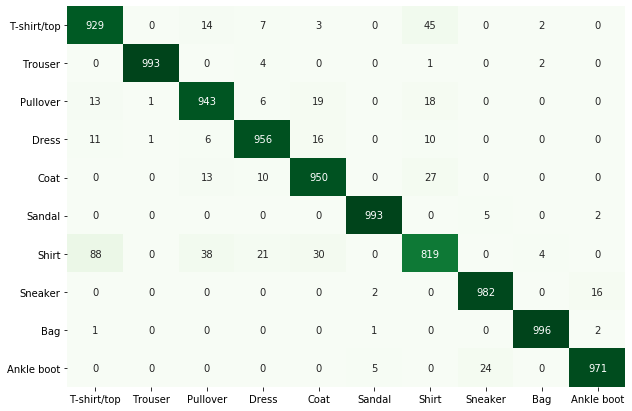

In [173]:
# plot confusion matrix
plot_confusion_matrix(model_reprod, testloader)

### REALWORLD-SETTINGS EVALUATION

In [174]:
import PIL
from PIL import Image

In [175]:
imgs = ["Bag.png", "PullOver.png", "Sneaker.png", "Top.png", "Trouser.png"]
images = []
# load images from imgs folder
for img in imgs:
    images.append(Image.open("./imgs/{}".format(img)))

In [176]:
def display_imgs(images):
    """
    Call this function to display images
    """
    for i, img in enumerate(images):
        plt.subplot(len(images),i+1,1)
        # remove x ticks and y ticks around the images
        plt.xticks([])
        plt.yticks([])
        # display the image
        plt.imshow(img)
        plt.show()

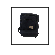

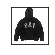

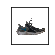

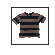

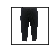

In [177]:
display_imgs(images)

In [178]:
# Convert images to grey scale
grey_images = []
for img in images:
    grey_images.append(img.convert("L"))
grey_images 

[<PIL.Image.Image image mode=L size=500x500 at 0x140E44460>,
 <PIL.Image.Image image mode=L size=500x500 at 0x140B5E310>,
 <PIL.Image.Image image mode=L size=500x500 at 0x12C5B5670>,
 <PIL.Image.Image image mode=L size=500x500 at 0x12C5B5A60>,
 <PIL.Image.Image image mode=L size=500x500 at 0x12C5B56A0>]

In [179]:
# resize the images
for img in grey_images :
    img.thumbnail((28,28))
grey_images 

[<PIL.Image.Image image mode=L size=28x28 at 0x140E44460>,
 <PIL.Image.Image image mode=L size=28x28 at 0x140B5E310>,
 <PIL.Image.Image image mode=L size=28x28 at 0x12C5B5670>,
 <PIL.Image.Image image mode=L size=28x28 at 0x12C5B5A60>,
 <PIL.Image.Image image mode=L size=28x28 at 0x12C5B56A0>]

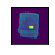

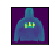

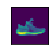

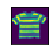

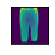

In [180]:
display_imgs(grey_images)

In [181]:
class CustomTensorDataset(Dataset):
    """
    This custom dataset class allows us to apply transform to the input images
    """
    def __init__(self, tensors, transform=None):
        self.tensors = tensors
        self.transform = transform

    def __getitem__(self, index):
        x = self.tensors[index]
        if self.transform:
            x = self.transform(x)
        return x

    def __len__(self):
        return self.tensors.size(0)

# create realset from list of grey images and also apply the transformation to the images
realset = CustomTensorDataset(grey_images, transform=transform_test)

In [191]:
# transform the images to the approriate format (tensor) for the model
outputs = []
for img in realset:
    outputs.append(img)
outputs = torch.cat(outputs, dim=0)
outputs = outputs.view(5,1,28,28)

In [192]:
# make prediction
predictions = model_reprod(a)

In [193]:
# extract the predicted labels from model's outputs
preds = []
for tensor in predictions:
    preds.append(argmax(tensor, dim=0).item())

In [194]:
outputs.shape

torch.Size([5, 1, 28, 28])

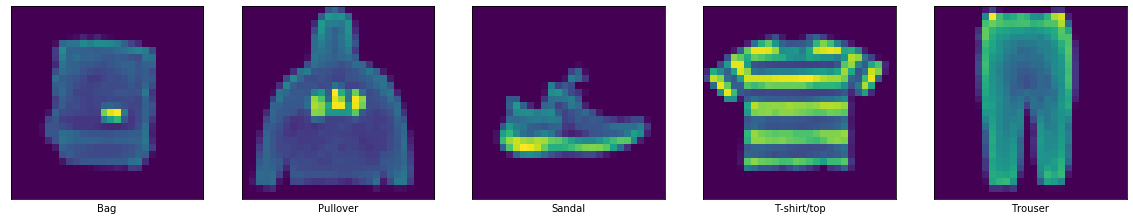

In [195]:
# plot the images with their associating predicted labels
plt.figure(figsize=(20,20))
for i in range(5):
    # add a subplot to the current figure
    plt.subplot(1,5,i+1)
    # remove x ticks and y ticks around the images
    plt.xticks([])
    plt.yticks([])
    # display the image
    plt.imshow(outputs[i].reshape(28,28))
    # displaye the corresponding labels
    plt.xlabel(class_names[preds[i]])
plt.show()

Comment: the model guesses correctly 4 out 5 images. It is mistaken about the label for the sneaker image.